This notebook is to help us re-engineer the WFST code written by me in 2016.  The code has Ozymandian qualities, as though it was written by another civilisation.  There are loosely three parts to the code:

* prosodic models
* language model
* sentence-length model

We need to generate separate WFSTs for these different steps and then combine them together into a single WFST.

In [35]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
import argparse
import os
import sys
import shutil
import glob

from mseg import lm_utils, evaluate_output

from mseg.common import create_remap_table, read_file, LM_SYM_FILE, SYM_FILE, load_symbol_table, save_symbol_table
from mseg.lm_utils import generate_normed_text_file, compile_lm, remap_lm, ngramshrink
from mseg.slm_utils import generate_slm_from_txt, create_slm_sym_file
from mseg.create_gold_files import generate_gold_files
from mseg.pm_utils import generate_pm_text_files, compile_pm_files
from mseg.find_shortest_paths import stringify_shortest_paths, convert_to_single_file
from mseg import bleu_break_scorer
from mseg import reporting_utils

#nltk.download()
do_build = True
#eq_chance=  False
compose_lm_slm = True
SYMBOL_COL = 5

UNK = "<unk>"
BREAK = "<break>"
ANYWORD = "<w>"
EPS = "<epsilon>"

tr_file = "/home/rjm49/Dropbox/nlp_alta/recreate_LG/tt_data/eval1-prosodicFeats_norm_train.csv"
tt_file = "/home/rjm49/Dropbox/nlp_alta/recreate_LG/tt_data/eval1-prosodicFeats_norm_test.csv"



In [131]:
def write_bleus_to_file(R, cands, bfile, order=4, strict=True):
    smode = "strict" if strict else "lax"    
    bfile.write("BLEU-%d SCORES (%s)\n" % (order, smode))
    for cpair in cands:
        c_name = cpair[0]
        C = cpair[1]
        bleu_pair = bleu_break_scorer.getBLEU(C, R, N=order, strict=strict)
        
        
#         print c_name, order, smode, bleu_pair
        
        bfile.write("%s = %f \n" % (c_name, bleu_pair[0]))
#         bfile.write("Mod'd prec'ns:\n")
        for p in enumerate(bleu_pair[1]):
            bfile.write("p_%d=%f " % (p[0]+1, p[1]))
        BP = bleu_pair[2]
        if(BP<1.0):
            bfile.write("Brev pen=%f\n" % BP)
        bfile.write("\n")
    bfile.write("- - - - -\n")

In [132]:
#     parser = argparse.ArgumentParser()
#     parser.add_argument("base_dir", nargs='?', default= os.path.join(os.getcwd(),"mseg_workspace"), help="this is the working directory, all sub dirs live under it")
#     parser.add_argument("lm_dir", nargs='?', default="lm_default", help="this is the directory in which to store the Language Model (LM) files")
#     parser.add_argument("training_file", nargs='?', default=TRAIN_FILE_DEFAULT, help="name of CSV file that contains correctly annotated training examples")
#     parser.add_argument("-o", "--order", type=int, default=4, help="sets the n-gramme order of the LM (default=4)")
#     args = parser.parse_args()
import nltk
def posify(te_rows):
    segs = []
    for t in te_rows:
        if not t[0] in segs:
            segs.append(t[0])
    
    emission_vals = []
    for seg in segs:
        ws = [t[SYMBOL_COL] for t in te_rows if t[0] == seg]
        ws = [x.upper() if (len(x) == 1 and x != 'a') else x for x in ws]
        print("For seg=", seg, "got these tokens:", ws)
        tags = nltk.pos_tag(ws)
        print("tags=", tags)
        for tag in tags:
            emission_vals.append(tag[1])
    return emission_vals

In [133]:
def process_inputs(input_dir, lm_file, out_dir):
    if(not os.path.exists(input_dir)):
        print("FST source directory",input_dir,"does not exist - can't continue analysis without it!")
        exit(1)
       
    #create/refresh the working directory
    print("remaking ", out_dir)
    shutil.rmtree(out_dir, ignore_errors=True)
    os.makedirs(out_dir)
    
    fs = glob.glob(os.path.join(input_dir,"*.fst"))
    for f in fs:
        fn = os.path.basename(f)
        print(out_dir," -j- ", fn)
        outf = os.path.join(out_dir, fn)
        lm_utils.fstcompose(f, lm_file, outf)
        print("output:",outf)

global lmdir: ./models/language_models
number of tokens loaded: 61237
./models/language_models/normed.txt already exists.  Using existing file...
checking for LM file ./models/language_models/lm.mod
model file in ./models/language_models already exists.  Overwrite? [n]y
wrote symbol table  ./models/language_models/lm_sym.dat
save lm sym file to ./models/language_models/lm_sym.dat
farcompiled strings
created ./models/language_models/lm.cnt
counted ngrammes
calling ngrammake on ./models/language_models/lm.cnt
created ./models/language_models/lm.mod
made ngrammes
wrote symbol table  ./models/language_models/lm_sym.dat
save lm sym file to ./models/language_models/lm_sym.dat
farcompiled strings
created ./models/language_models/lm.cnt
counted ngrammes
calling ngrammake on ./models/language_models/lm.cnt
created ./models/language_models/lm.mod
made ngrammes
wrote remap pairs table  ./models/language_models/lm_remap.dat
remapped modfile output symbols
new max length =  16
new max length =  22


/home/rjm49/git/multistage_segmenter/mseg/slm_utils.py:179: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  #         print(gam_gen.pdf(i), sum(els))


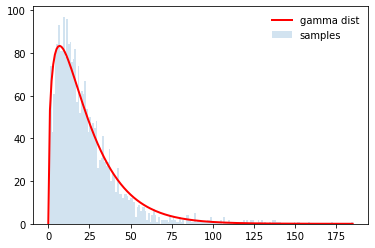

slm generated from /home/rjm49/Dropbox/nlp_alta/recreate_LG/tt_data/eval1-prosodicFeats_norm_train.csv in ./models/sentence_length_models
all constituent system files now compiled


In [135]:
base_dir = "./models"
pm_dir = "prosodic_models"
lm_dir = "language_models"
slm_dir = "sentence_length_models"

test_fname = "eval1"
ngo = 3 #this is the n_gramme order

#SECTION ONE: dedicated to creating the Language Model files    
lmdir_global = os.path.join(base_dir, lm_dir)

print("global lmdir:", lmdir_global)

tr_rows = read_file(os.path.join(base_dir, tr_file), ',', skip_header=True)

rawtext_file = generate_normed_text_file(tr_rows, lmdir_global)

#lm_syms = set([r[5] for r in tr_rows])

lm_txt = open(rawtext_file, "r").readlines()
lm_syms= set( open(rawtext_file, "r").read().split() )
if BREAK in lm_syms: lm_syms.remove(BREAK)
if UNK in lm_syms: lm_syms.remove(UNK)

buildmod = "y"
modfile = os.path.join(lmdir_global,"lm.mod")
modpru = os.path.join(lmdir_global,LM_PRUNED)

print("checking for LM file",modfile)
if(os.path.exists(modfile)):
    buildmod = input("model file in "+lmdir_global+" already exists.  Overwrite? [n]").lower() or "n"

if(not buildmod=="n"):
    modfile = compile_lm(rawtext_file, lmdir_global, lm_syms, ngo)

#     print("Created unpruned lang model file:", modfile)
#     print("Now pruning LM...")
#     ngramshrink(modfile, modpru)
#     #print "Now minimising LM..."
#     #lm_utils.fstmin(modpru,modpru)

#     #we don't use the unpruned modfile again, so switch over to the pruned version here
#     modfile = modpru
    modfile = compile_lm(rawtext_file, lmdir_global, lm_syms, ngo)
    remap_fname = os.path.join(lmdir_global,"lm_remap.dat")
    create_remap_table(lm_syms, remap_fname)


    osymfile = os.path.join(base_dir,"slm_sym.dat")
    create_slm_sym_file(osymfile)
    remap_lm(modfile, remap_fname, osymfile)
    print("remapped modfile output symbols")

#create_converter(lmdir_global)
#print "created converter."

#     slm_dir = raw_input("Type in SLM dir or hit return to match LM [%s]" % lm_dir) or lm_dir
#     slm_dir = os.path.join(base_dir,slm_dir)
#         
#     print "using ",slm_dir

#put the SLM model into the same directory as its corresponding LM
slm_dir = os.path.join(base_dir, slm_dir)
generate_slm_from_txt(lm_txt, slm_dir, do_plot=True)
#generate_slm(tr_rows, slm_dir, do_plot=False) # build the sentence length model, plot it so we can see it's sane
print("slm generated from", tr_file, "in", slm_dir)

print("all constituent system files now compiled")

In [136]:
## method to load data

batch_dir="./models"
# batch_dir = os.path.join(base_dir, "BATCH")
# lm_dir = os.path.join(base_dir, batch['language_model'])
# pm_dir = os.path.join(base_dir, batch['prosodic_model'])
# slm_dir = os.path.join(base_dir,batch['length_model'])
tt_file = "/home/rjm49/Dropbox/nlp_alta/recreate_LG/tt_data/eval1-prosodicFeats_norm_test.csv"
tep_file = "eval1"

use_pos_tags = False #batch.get('use_pos_tags', False)
pm_weight = 1#batch.get('pm_weight', 1)

gold_dir = os.path.join(batch_dir, "gold")
all_models_dir = os.path.join(batch_dir, "pm_lm_slm")

all_models_out_dir = os.path.join(all_models_dir, "output")
all_models_in_dir = os.path.join(all_models_dir, "composed")
all_models_shp_dir = os.path.join(all_models_dir, "shortest")

pm_only_dir = os.path.join(batch_dir, "pm_only")
pm_shp_dir = os.path.join(pm_only_dir, "shortest")
pm_outs_dir = os.path.join(pm_only_dir, "output")

pm_lm_dir = os.path.join(batch_dir, "pm_lm")
pm_lm_in_dir = os.path.join(pm_lm_dir, "composed")
pm_lm_shp_dir = os.path.join(pm_lm_dir, "shortest")
pm_lm_outs_dir = os.path.join(pm_lm_dir, "output")

pm_slm_dir = os.path.join(batch_dir, "pm_slm")
pm_slm_in_dir = os.path.join(pm_slm_dir, "composed")
pm_slm_shp_dir = os.path.join(pm_slm_dir, "shortest")
pm_slm_outs_dir = os.path.join(pm_slm_dir, "output")

do_build=True
if(do_build): 
    #lmdir_global = os.path.join(base_dir,lm_dir)
    batch_input_fst_dir = os.path.join(batch_dir, "speech_fsts")
    if not os.path.exists(batch_input_fst_dir):
        os.makedirs(batch_input_fst_dir)

    te_rows = read_file(tt_file, ',', skip_header=True)

    generate_gold_files(gold_dir, te_rows)

    #ONE: make speech_fsts from te_rows
    lmsym_fname = os.path.join(batch_dir,lm_dir,LM_SYM_FILE)
    print("lmsym_fname",lmsym_fname)
    
    lm_syms = load_symbol_table(lmsym_fname)
    
    te_syms = [r[SYMBOL_COL] for r in te_rows]

    all_syms = set(lm_syms + te_syms)
    pmsym_fname = os.path.join(batch_dir, SYM_FILE)
    save_symbol_table(all_syms, pmsym_fname)
    probability_file = os.path.join(batch_dir, pm_dir, (tep_file+"-probabilities.dat"))
    if not os.path.exists(probability_file):
        print("No prosodic probability file found: ", probability_file, " - you need to create this first with train_pm.py")
        assert(False)
#         continue #go onto the next batch TODO should create prob file here!
    else:
        print("Using prosodic probability file:", probability_file)

    prob_rows = read_file(probability_file, ' ', skip_header=True)

    if use_pos_tags:
        emission_vals = posify(te_rows)
    else:
        emission_vals = te_syms


    generate_pm_text_files(batch_input_fst_dir, lm_syms, te_rows, prob_rows, max_count=-1, emission_values=emission_vals, pm_weight=pm_weight)
    compile_pm_files(batch_input_fst_dir, pmsym_fname, lmsym_fname)

number of tokens loaded: 6792
wrote 6792 gold files to ./models/gold
lmsym_fname ./models/language_models/lm_sym.dat
number of tokens loaded: 3989
wrote symbol table  ./models/sym.dat
Using prosodic probability file: ./models/prosodic_models/eval1-probabilities.dat
number of tokens loaded: 6792
wrote 6792 prosodic model txt files to ./models/speech_fsts
compiling ./models/speech_fsts/S3KS68D5GG_SC_01.fst
compiled ./models/speech_fsts/S3KS68D5GG_SC_01.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S247XV35QK_SE_03.fst
compiled ./models/speech_fsts/S247XV35QK_SE_03.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S3WXPCUE47_SE_02.fst
compiled ./models/speech_fsts/S3WXPCUE47_SE_02.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S2BDQ6WDWT_SD_01.fst
compiled ./models/speech_fsts/S2BDQ6WDWT_SD_01.fst with isyms= .

compiled ./models/speech_fsts/S2XP3M3EQ9_SC_01.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S2BDQ6WDWT_SE_02.fst
compiled ./models/speech_fsts/S2BDQ6WDWT_SE_02.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S2PGHPT4GM_SE_02.fst
compiled ./models/speech_fsts/S2PGHPT4GM_SE_02.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S3KS68D5GG_SE_01.fst
compiled ./models/speech_fsts/S3KS68D5GG_SE_01.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S36S4HCDUW_SE_04.fst
compiled ./models/speech_fsts/S36S4HCDUW_SE_04.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S2Y5PKHZA8_SD_01.fst
compiled ./models/speech_fsts/S2Y5PKHZA8_SD_01.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.

compiled ./models/speech_fsts/S2SG3Q2V56_SE_02.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S36B37NNP7_SC_01.fst
compiled ./models/speech_fsts/S36B37NNP7_SC_01.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S3WXPCUE47_SE_05.fst
compiled ./models/speech_fsts/S3WXPCUE47_SE_05.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S2PGHPT4GM_SD_01.fst
compiled ./models/speech_fsts/S2PGHPT4GM_SD_01.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S3KVR8CNFZ_SE_05.fst
compiled ./models/speech_fsts/S3KVR8CNFZ_SE_05.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.dat
compiling ./models/speech_fsts/S2NCW57TBV_SE_01.fst
compiled ./models/speech_fsts/S2NCW57TBV_SE_01.fst with isyms= ./models/sym.dat  osyms= ./models/language_models/lm_sym.

In [137]:
    #TWO: Assuming all the other model files are complete, we should be good to go

    #lang_mod = os.path.join(lm_dir,LM_PRUNED)
#     lang_mod = os.path.join(lmdir_global,"mod.pru")
    lang_mod = os.path.join(lmdir_global,"lm.mod")


    print("joined up working dir names")
    stringify_shortest_paths("./models/speech_fsts", "./models/pm_only/shortest", pm_outs_dir)

    #now just use the pruned LM file without slen modifier
    print(batch_input_fst_dir, lang_mod, pm_lm_in_dir)
    print("ps'ing")
    process_inputs("./models/speech_fsts", lang_mod, "./models/pm_lm/composed")#TODO paths going wrong here!
    print("stringify")
    stringify_shortest_paths(pm_lm_in_dir, pm_lm_shp_dir, pm_lm_outs_dir) #(input_dir, shortpath_dir, strings_dir
#     assert(False)
    
    #use combined LM and slen modifier
    slm_file = os.path.join(slm_dir,"slm.fst")
    lm_slm = os.path.join(batch_dir,"lm_slm.fst") 

    compose_lm_slm = True
    if compose_lm_slm:
        lm_utils.fstarcsort(slm_file, ilabel_sort=True)
        lm_utils.fstcompose(lang_mod, slm_file, lm_slm)
        lm_utils.fstimmut(lm_slm, lm_slm)

        process_inputs(batch_input_fst_dir, lm_slm, all_models_in_dir)
#     assert(False)
    

joined up working dir names
stringify sp: re-making ./models/pm_only/shortest
stringify sp: re-making ./models/pm_only/output
processing files matching: ./models/speech_fsts/*.fst
134 files found
Finding shortest path: ./models/speech_fsts/S2PGHPT4GM_SE_01.fst -> ./models/pm_only/output/S2PGHPT4GM_SE_01.fst
First, create temp file: ./models/pm_only/shortest/S2PGHPT4GM_SE_01.fst
reading ./models/pm_only/shortest/S2PGHPT4GM_SE_01.fst
Finding shortest path: ./models/speech_fsts/S2DN556XDR_SE_02.fst -> ./models/pm_only/output/S2DN556XDR_SE_02.fst
First, create temp file: ./models/pm_only/shortest/S2DN556XDR_SE_02.fst
reading ./models/pm_only/shortest/S2DN556XDR_SE_02.fst
Finding shortest path: ./models/speech_fsts/S2Y5PKHZA8_SD_01.fst -> ./models/pm_only/output/S2Y5PKHZA8_SD_01.fst
First, create temp file: ./models/pm_only/shortest/S2Y5PKHZA8_SD_01.fst
reading ./models/pm_only/shortest/S2Y5PKHZA8_SD_01.fst
Finding shortest path: ./models/speech_fsts/S2UBQHXQMT_SE_03.fst -> ./models/pm_only

reading ./models/pm_only/shortest/S37N46JJKH_SD_01.fst
Finding shortest path: ./models/speech_fsts/S2PGHPT4GM_SE_04.fst -> ./models/pm_only/output/S2PGHPT4GM_SE_04.fst
First, create temp file: ./models/pm_only/shortest/S2PGHPT4GM_SE_04.fst
reading ./models/pm_only/shortest/S2PGHPT4GM_SE_04.fst
Finding shortest path: ./models/speech_fsts/S37N46JJKH_SE_02.fst -> ./models/pm_only/output/S37N46JJKH_SE_02.fst
First, create temp file: ./models/pm_only/shortest/S37N46JJKH_SE_02.fst
reading ./models/pm_only/shortest/S37N46JJKH_SE_02.fst
Finding shortest path: ./models/speech_fsts/S32DT6JZW7_SE_02.fst -> ./models/pm_only/output/S32DT6JZW7_SE_02.fst
First, create temp file: ./models/pm_only/shortest/S32DT6JZW7_SE_02.fst
reading ./models/pm_only/shortest/S32DT6JZW7_SE_02.fst
Finding shortest path: ./models/speech_fsts/S2WHT5J7J5_SE_04.fst -> ./models/pm_only/output/S2WHT5J7J5_SE_04.fst
First, create temp file: ./models/pm_only/shortest/S2WHT5J7J5_SE_04.fst
reading ./models/pm_only/shortest/S2WHT5

Finding shortest path: ./models/speech_fsts/S2DN556XDR_SE_03.fst -> ./models/pm_only/output/S2DN556XDR_SE_03.fst
First, create temp file: ./models/pm_only/shortest/S2DN556XDR_SE_03.fst
reading ./models/pm_only/shortest/S2DN556XDR_SE_03.fst
Finding shortest path: ./models/speech_fsts/S2BDQ6WDWT_SE_02.fst -> ./models/pm_only/output/S2BDQ6WDWT_SE_02.fst
First, create temp file: ./models/pm_only/shortest/S2BDQ6WDWT_SE_02.fst
reading ./models/pm_only/shortest/S2BDQ6WDWT_SE_02.fst
Finding shortest path: ./models/speech_fsts/S36B37NNP7_SE_01.fst -> ./models/pm_only/output/S36B37NNP7_SE_01.fst
First, create temp file: ./models/pm_only/shortest/S36B37NNP7_SE_01.fst
reading ./models/pm_only/shortest/S36B37NNP7_SE_01.fst
Finding shortest path: ./models/speech_fsts/S2KNF7ZPAF_SC_01.fst -> ./models/pm_only/output/S2KNF7ZPAF_SC_01.fst
First, create temp file: ./models/pm_only/shortest/S2KNF7ZPAF_SC_01.fst
reading ./models/pm_only/shortest/S2KNF7ZPAF_SC_01.fst
Finding shortest path: ./models/speech_f

reading ./models/pm_only/shortest/S2BDQ6WDWT_SE_03.fst
Finding shortest path: ./models/speech_fsts/S2WHT5J7J5_SD_01.fst -> ./models/pm_only/output/S2WHT5J7J5_SD_01.fst
First, create temp file: ./models/pm_only/shortest/S2WHT5J7J5_SD_01.fst
reading ./models/pm_only/shortest/S2WHT5J7J5_SD_01.fst
Finding shortest path: ./models/speech_fsts/S36B37NNP7_SE_02.fst -> ./models/pm_only/output/S36B37NNP7_SE_02.fst
First, create temp file: ./models/pm_only/shortest/S36B37NNP7_SE_02.fst
reading ./models/pm_only/shortest/S36B37NNP7_SE_02.fst
Finding shortest path: ./models/speech_fsts/S32DT6JZW7_SE_01.fst -> ./models/pm_only/output/S32DT6JZW7_SE_01.fst
First, create temp file: ./models/pm_only/shortest/S32DT6JZW7_SE_01.fst
reading ./models/pm_only/shortest/S32DT6JZW7_SE_01.fst
Finding shortest path: ./models/speech_fsts/S2SG3Q2V56_SE_05.fst -> ./models/pm_only/output/S2SG3Q2V56_SE_05.fst
First, create temp file: ./models/pm_only/shortest/S2SG3Q2V56_SE_05.fst
reading ./models/pm_only/shortest/S2SG3Q

output: ./models/pm_lm/composed/S3KVR8CNFZ_SD_01.fst
./models/pm_lm/composed  -j-  S247XV35QK_SE_04.fst
composing ./models/speech_fsts/S247XV35QK_SE_04.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S247XV35QK_SE_04.fst
output: ./models/pm_lm/composed/S247XV35QK_SE_04.fst
./models/pm_lm/composed  -j-  S2NCW57TBV_SE_01.fst
composing ./models/speech_fsts/S2NCW57TBV_SE_01.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S2NCW57TBV_SE_01.fst
output: ./models/pm_lm/composed/S2NCW57TBV_SE_01.fst
./models/pm_lm/composed  -j-  S2UBQHXQMT_SD_01.fst
composing ./models/speech_fsts/S2UBQHXQMT_SD_01.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S2UBQHXQMT_SD_01.fst
output: ./models/pm_lm/composed/S2UBQHXQMT_SD_01.fst
./models/pm_lm/composed  -j-  S3KS68D5GG_SE_05.fst
composing ./models/speech_fsts/S3KS68D5GG_SE_05.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S3KS68D5GG_SE_05.fst
output: ./models/pm_lm/composed/S3KS68D5GG_SE_05.fst
./m

output: ./models/pm_lm/composed/S3KVR8CNFZ_SE_02.fst
./models/pm_lm/composed  -j-  S36S4HCDUW_SD_01.fst
composing ./models/speech_fsts/S36S4HCDUW_SD_01.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S36S4HCDUW_SD_01.fst
output: ./models/pm_lm/composed/S36S4HCDUW_SD_01.fst
./models/pm_lm/composed  -j-  S247XV35QK_SD_01.fst
composing ./models/speech_fsts/S247XV35QK_SD_01.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S247XV35QK_SD_01.fst
output: ./models/pm_lm/composed/S247XV35QK_SD_01.fst
./models/pm_lm/composed  -j-  S3WXPCUE47_SE_03.fst
composing ./models/speech_fsts/S3WXPCUE47_SE_03.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S3WXPCUE47_SE_03.fst
output: ./models/pm_lm/composed/S3WXPCUE47_SE_03.fst
./models/pm_lm/composed  -j-  S36S4HCDUW_SE_05.fst
composing ./models/speech_fsts/S36S4HCDUW_SE_05.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S36S4HCDUW_SE_05.fst
output: ./models/pm_lm/composed/S36S4HCDUW_SE_05.fst
./m

output: ./models/pm_lm/composed/S3KS68D5GG_SC_01.fst
./models/pm_lm/composed  -j-  S2NCW57TBV_SE_05.fst
composing ./models/speech_fsts/S2NCW57TBV_SE_05.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S2NCW57TBV_SE_05.fst
output: ./models/pm_lm/composed/S2NCW57TBV_SE_05.fst
./models/pm_lm/composed  -j-  S2UBQHXQMT_SE_04.fst
composing ./models/speech_fsts/S2UBQHXQMT_SE_04.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S2UBQHXQMT_SE_04.fst
output: ./models/pm_lm/composed/S2UBQHXQMT_SE_04.fst
./models/pm_lm/composed  -j-  S2NCW57TBV_SC_01.fst
composing ./models/speech_fsts/S2NCW57TBV_SC_01.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S2NCW57TBV_SC_01.fst
output: ./models/pm_lm/composed/S2NCW57TBV_SC_01.fst
./models/pm_lm/composed  -j-  S2DN556XDR_SE_01.fst
composing ./models/speech_fsts/S2DN556XDR_SE_01.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S2DN556XDR_SE_01.fst
output: ./models/pm_lm/composed/S2DN556XDR_SE_01.fst
./m

output: ./models/pm_lm/composed/S2PGHPT4GM_SC_01.fst
./models/pm_lm/composed  -j-  S2XP3M3EQ9_SC_01.fst
composing ./models/speech_fsts/S2XP3M3EQ9_SC_01.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S2XP3M3EQ9_SC_01.fst
output: ./models/pm_lm/composed/S2XP3M3EQ9_SC_01.fst
./models/pm_lm/composed  -j-  S2F4VD4NK8_SE_01.fst
composing ./models/speech_fsts/S2F4VD4NK8_SE_01.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S2F4VD4NK8_SE_01.fst
output: ./models/pm_lm/composed/S2F4VD4NK8_SE_01.fst
./models/pm_lm/composed  -j-  S2SG3Q2V56_SE_02.fst
composing ./models/speech_fsts/S2SG3Q2V56_SE_02.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S2SG3Q2V56_SE_02.fst
output: ./models/pm_lm/composed/S2SG3Q2V56_SE_02.fst
./models/pm_lm/composed  -j-  S37N46JJKH_SE_05.fst
composing ./models/speech_fsts/S37N46JJKH_SE_05.fst ./models/language_models/lm.mod -> ./models/pm_lm/composed/S37N46JJKH_SE_05.fst
output: ./models/pm_lm/composed/S37N46JJKH_SE_05.fst
./m

reading ./models/pm_lm/shortest/S2XP3M3EQ9_SE_01.fst
Finding shortest path: ./models/pm_lm/composed/S3KVR8CNFZ_SC_01.fst -> ./models/pm_lm/output/S3KVR8CNFZ_SC_01.fst
First, create temp file: ./models/pm_lm/shortest/S3KVR8CNFZ_SC_01.fst
reading ./models/pm_lm/shortest/S3KVR8CNFZ_SC_01.fst
Finding shortest path: ./models/pm_lm/composed/S3X7KSJ2J2_SD_01.fst -> ./models/pm_lm/output/S3X7KSJ2J2_SD_01.fst
First, create temp file: ./models/pm_lm/shortest/S3X7KSJ2J2_SD_01.fst
reading ./models/pm_lm/shortest/S3X7KSJ2J2_SD_01.fst
Finding shortest path: ./models/pm_lm/composed/S36S4HCDUW_SE_02.fst -> ./models/pm_lm/output/S36S4HCDUW_SE_02.fst
First, create temp file: ./models/pm_lm/shortest/S36S4HCDUW_SE_02.fst
reading ./models/pm_lm/shortest/S36S4HCDUW_SE_02.fst
Finding shortest path: ./models/pm_lm/composed/S2XP3M3EQ9_SD_01.fst -> ./models/pm_lm/output/S2XP3M3EQ9_SD_01.fst
First, create temp file: ./models/pm_lm/shortest/S2XP3M3EQ9_SD_01.fst
reading ./models/pm_lm/shortest/S2XP3M3EQ9_SD_01.fst

reading ./models/pm_lm/shortest/S2SG3Q2V56_SE_03.fst
Finding shortest path: ./models/pm_lm/composed/S36B37NNP7_SD_01.fst -> ./models/pm_lm/output/S36B37NNP7_SD_01.fst
First, create temp file: ./models/pm_lm/shortest/S36B37NNP7_SD_01.fst
reading ./models/pm_lm/shortest/S36B37NNP7_SD_01.fst
Finding shortest path: ./models/pm_lm/composed/S37N46JJKH_SE_04.fst -> ./models/pm_lm/output/S37N46JJKH_SE_04.fst
First, create temp file: ./models/pm_lm/shortest/S37N46JJKH_SE_04.fst
reading ./models/pm_lm/shortest/S37N46JJKH_SE_04.fst
Finding shortest path: ./models/pm_lm/composed/S3WXPCUE47_SD_01.fst -> ./models/pm_lm/output/S3WXPCUE47_SD_01.fst
First, create temp file: ./models/pm_lm/shortest/S3WXPCUE47_SD_01.fst
reading ./models/pm_lm/shortest/S3WXPCUE47_SD_01.fst
Finding shortest path: ./models/pm_lm/composed/S36B37NNP7_SE_05.fst -> ./models/pm_lm/output/S36B37NNP7_SE_05.fst
First, create temp file: ./models/pm_lm/shortest/S36B37NNP7_SE_05.fst
reading ./models/pm_lm/shortest/S36B37NNP7_SE_05.fst

reading ./models/pm_lm/shortest/S2DN556XDR_SC_01.fst
Finding shortest path: ./models/pm_lm/composed/S34EH9UV5V_SE_05.fst -> ./models/pm_lm/output/S34EH9UV5V_SE_05.fst
First, create temp file: ./models/pm_lm/shortest/S34EH9UV5V_SE_05.fst
reading ./models/pm_lm/shortest/S34EH9UV5V_SE_05.fst
Finding shortest path: ./models/pm_lm/composed/S37N46JJKH_SE_03.fst -> ./models/pm_lm/output/S37N46JJKH_SE_03.fst
First, create temp file: ./models/pm_lm/shortest/S37N46JJKH_SE_03.fst
reading ./models/pm_lm/shortest/S37N46JJKH_SE_03.fst
Finding shortest path: ./models/pm_lm/composed/S247XV35QK_SE_01.fst -> ./models/pm_lm/output/S247XV35QK_SE_01.fst
First, create temp file: ./models/pm_lm/shortest/S247XV35QK_SE_01.fst
reading ./models/pm_lm/shortest/S247XV35QK_SE_01.fst
Finding shortest path: ./models/pm_lm/composed/S3KS68D5GG_SE_02.fst -> ./models/pm_lm/output/S3KS68D5GG_SE_02.fst
First, create temp file: ./models/pm_lm/shortest/S3KS68D5GG_SE_02.fst
reading ./models/pm_lm/shortest/S3KS68D5GG_SE_02.fst

reading ./models/pm_lm/shortest/S3X7KSJ2J2_SC_01.fst
Finding shortest path: ./models/pm_lm/composed/S3WXPCUE47_SE_05.fst -> ./models/pm_lm/output/S3WXPCUE47_SE_05.fst
First, create temp file: ./models/pm_lm/shortest/S3WXPCUE47_SE_05.fst
reading ./models/pm_lm/shortest/S3WXPCUE47_SE_05.fst
Finding shortest path: ./models/pm_lm/composed/S3KVR8CNFZ_SE_01.fst -> ./models/pm_lm/output/S3KVR8CNFZ_SE_01.fst
First, create temp file: ./models/pm_lm/shortest/S3KVR8CNFZ_SE_01.fst
reading ./models/pm_lm/shortest/S3KVR8CNFZ_SE_01.fst
Finding shortest path: ./models/pm_lm/composed/S37N46JJKH_SE_01.fst -> ./models/pm_lm/output/S37N46JJKH_SE_01.fst
First, create temp file: ./models/pm_lm/shortest/S37N46JJKH_SE_01.fst
reading ./models/pm_lm/shortest/S37N46JJKH_SE_01.fst
Finding shortest path: ./models/pm_lm/composed/S34EH9UV5V_SE_02.fst -> ./models/pm_lm/output/S34EH9UV5V_SE_02.fst
First, create temp file: ./models/pm_lm/shortest/S34EH9UV5V_SE_02.fst
reading ./models/pm_lm/shortest/S34EH9UV5V_SE_02.fst

output: ./models/pm_lm_slm/composed/S3KVR8CNFZ_SE_03.fst
./models/pm_lm_slm/composed  -j-  S32DT6JZW7_SD_01.fst
composing ./models/speech_fsts/S32DT6JZW7_SD_01.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S32DT6JZW7_SD_01.fst
output: ./models/pm_lm_slm/composed/S32DT6JZW7_SD_01.fst
./models/pm_lm_slm/composed  -j-  S2XP3M3EQ9_SE_02.fst
composing ./models/speech_fsts/S2XP3M3EQ9_SE_02.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2XP3M3EQ9_SE_02.fst
output: ./models/pm_lm_slm/composed/S2XP3M3EQ9_SE_02.fst
./models/pm_lm_slm/composed  -j-  S2KNF7ZPAF_SE_04.fst
composing ./models/speech_fsts/S2KNF7ZPAF_SE_04.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2KNF7ZPAF_SE_04.fst
output: ./models/pm_lm_slm/composed/S2KNF7ZPAF_SE_04.fst
./models/pm_lm_slm/composed  -j-  S2UBQHXQMT_SC_01.fst
composing ./models/speech_fsts/S2UBQHXQMT_SC_01.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2UBQHXQMT_SC_01.fst
output: ./models/pm_lm_slm/composed/S2UBQHXQMT_SC_01.fst

output: ./models/pm_lm_slm/composed/S247XV35QK_SC_01.fst
./models/pm_lm_slm/composed  -j-  S34EH9UV5V_SE_04.fst
composing ./models/speech_fsts/S34EH9UV5V_SE_04.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S34EH9UV5V_SE_04.fst
output: ./models/pm_lm_slm/composed/S34EH9UV5V_SE_04.fst
./models/pm_lm_slm/composed  -j-  S36B37NNP7_SE_03.fst
composing ./models/speech_fsts/S36B37NNP7_SE_03.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S36B37NNP7_SE_03.fst
output: ./models/pm_lm_slm/composed/S36B37NNP7_SE_03.fst
./models/pm_lm_slm/composed  -j-  S2UBQHXQMT_SE_01.fst
composing ./models/speech_fsts/S2UBQHXQMT_SE_01.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2UBQHXQMT_SE_01.fst
output: ./models/pm_lm_slm/composed/S2UBQHXQMT_SE_01.fst
./models/pm_lm_slm/composed  -j-  S2WHT5J7J5_SE_05.fst
composing ./models/speech_fsts/S2WHT5J7J5_SE_05.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2WHT5J7J5_SE_05.fst
output: ./models/pm_lm_slm/composed/S2WHT5J7J5_SE_05.fst

output: ./models/pm_lm_slm/composed/S2KNF7ZPAF_SD_01.fst
./models/pm_lm_slm/composed  -j-  S2NCW57TBV_SE_04.fst
composing ./models/speech_fsts/S2NCW57TBV_SE_04.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2NCW57TBV_SE_04.fst
output: ./models/pm_lm_slm/composed/S2NCW57TBV_SE_04.fst
./models/pm_lm_slm/composed  -j-  S2F4VD4NK8_SD_01.fst
composing ./models/speech_fsts/S2F4VD4NK8_SD_01.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2F4VD4NK8_SD_01.fst
output: ./models/pm_lm_slm/composed/S2F4VD4NK8_SD_01.fst
./models/pm_lm_slm/composed  -j-  S2WHT5J7J5_SC_01.fst
composing ./models/speech_fsts/S2WHT5J7J5_SC_01.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2WHT5J7J5_SC_01.fst
output: ./models/pm_lm_slm/composed/S2WHT5J7J5_SC_01.fst
./models/pm_lm_slm/composed  -j-  S32DT6JZW7_SE_03.fst
composing ./models/speech_fsts/S32DT6JZW7_SE_03.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S32DT6JZW7_SE_03.fst
output: ./models/pm_lm_slm/composed/S32DT6JZW7_SE_03.fst

output: ./models/pm_lm_slm/composed/S34EH9UV5V_SD_01.fst
./models/pm_lm_slm/composed  -j-  S247XV35QK_SE_02.fst
composing ./models/speech_fsts/S247XV35QK_SE_02.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S247XV35QK_SE_02.fst
output: ./models/pm_lm_slm/composed/S247XV35QK_SE_02.fst
./models/pm_lm_slm/composed  -j-  S2SG3Q2V56_SE_04.fst
composing ./models/speech_fsts/S2SG3Q2V56_SE_04.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2SG3Q2V56_SE_04.fst
output: ./models/pm_lm_slm/composed/S2SG3Q2V56_SE_04.fst
./models/pm_lm_slm/composed  -j-  S2PGHPT4GM_SE_05.fst
composing ./models/speech_fsts/S2PGHPT4GM_SE_05.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2PGHPT4GM_SE_05.fst
output: ./models/pm_lm_slm/composed/S2PGHPT4GM_SE_05.fst
./models/pm_lm_slm/composed  -j-  S2DN556XDR_SE_04.fst
composing ./models/speech_fsts/S2DN556XDR_SE_04.fst ./models/lm_slm.fst -> ./models/pm_lm_slm/composed/S2DN556XDR_SE_04.fst
output: ./models/pm_lm_slm/composed/S2DN556XDR_SE_04.fst

In [138]:
batch_name = "default"

print("doing find shortest paths...")
print(all_models_in_dir)
print(all_models_shp_dir)
print(all_models_out_dir)
stringify_shortest_paths(all_models_in_dir, all_models_shp_dir, all_models_out_dir)

# assert(False)

R = convert_to_single_file("*.gld", gold_dir)        
C = convert_to_single_file("*.fst", all_models_out_dir)

PM_C = convert_to_single_file("*.fst", pm_outs_dir)
PMLM_C = convert_to_single_file("*.fst", pm_lm_outs_dir)

cands = (("PM", PM_C),
         ("PM_LM",PMLM_C),
         ("PM_LM_SLM",C))

evaluate_output.eval_segmenter_output(batch_dir)

mc_report = evaluate_output.multi_col_report(batch_dir)

mcrfile = open(os.path.join(batch_dir, "mc_report.csv"),"w")
for r in mc_report:
    rec_id = r["rec_id"]
    words = r["words"]
    gold = r["gold"]
    pm = r["pm_only"]
    pm_lm = r["pm_lm"]
    pm_lm_slm = r["pm_lm_slm"]

    mcrfile.write("recording, word, gold, pm_only, pm_lm, pm_lm_slm\n")
    for row in zip(words, gold, pm, pm_lm, pm_lm_slm):
        s = ",".join(row)
        s = rec_id + "," + s + "\n"
        mcrfile.write(s)
mcrfile.close()

doing find shortest paths...
./models/pm_lm_slm/composed
./models/pm_lm_slm/shortest
./models/pm_lm_slm/output
stringify sp: re-making ./models/pm_lm_slm/shortest
stringify sp: re-making ./models/pm_lm_slm/output
processing files matching: ./models/pm_lm_slm/composed/*.fst
134 files found
Finding shortest path: ./models/pm_lm_slm/composed/S2PGHPT4GM_SE_01.fst -> ./models/pm_lm_slm/output/S2PGHPT4GM_SE_01.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2PGHPT4GM_SE_01.fst
reading ./models/pm_lm_slm/shortest/S2PGHPT4GM_SE_01.fst
Finding shortest path: ./models/pm_lm_slm/composed/S2DN556XDR_SE_02.fst -> ./models/pm_lm_slm/output/S2DN556XDR_SE_02.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2DN556XDR_SE_02.fst
reading ./models/pm_lm_slm/shortest/S2DN556XDR_SE_02.fst
Finding shortest path: ./models/pm_lm_slm/composed/S2Y5PKHZA8_SD_01.fst -> ./models/pm_lm_slm/output/S2Y5PKHZA8_SD_01.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2Y5PKHZA8_SD_01.fst
reading 

reading ./models/pm_lm_slm/shortest/S37N46JJKH_SC_01.fst
Finding shortest path: ./models/pm_lm_slm/composed/S3WXPCUE47_SE_02.fst -> ./models/pm_lm_slm/output/S3WXPCUE47_SE_02.fst
First, create temp file: ./models/pm_lm_slm/shortest/S3WXPCUE47_SE_02.fst
reading ./models/pm_lm_slm/shortest/S3WXPCUE47_SE_02.fst
Finding shortest path: ./models/pm_lm_slm/composed/S2KNF7ZPAF_SE_01.fst -> ./models/pm_lm_slm/output/S2KNF7ZPAF_SE_01.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2KNF7ZPAF_SE_01.fst
reading ./models/pm_lm_slm/shortest/S2KNF7ZPAF_SE_01.fst
Finding shortest path: ./models/pm_lm_slm/composed/S37N46JJKH_SD_01.fst -> ./models/pm_lm_slm/output/S37N46JJKH_SD_01.fst
First, create temp file: ./models/pm_lm_slm/shortest/S37N46JJKH_SD_01.fst
reading ./models/pm_lm_slm/shortest/S37N46JJKH_SD_01.fst
Finding shortest path: ./models/pm_lm_slm/composed/S2PGHPT4GM_SE_04.fst -> ./models/pm_lm_slm/output/S2PGHPT4GM_SE_04.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2PGHPT4G

Finding shortest path: ./models/pm_lm_slm/composed/S2XP3M3EQ9_SE_05.fst -> ./models/pm_lm_slm/output/S2XP3M3EQ9_SE_05.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2XP3M3EQ9_SE_05.fst
reading ./models/pm_lm_slm/shortest/S2XP3M3EQ9_SE_05.fst
Finding shortest path: ./models/pm_lm_slm/composed/S2PGHPT4GM_SD_01.fst -> ./models/pm_lm_slm/output/S2PGHPT4GM_SD_01.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2PGHPT4GM_SD_01.fst
reading ./models/pm_lm_slm/shortest/S2PGHPT4GM_SD_01.fst
Finding shortest path: ./models/pm_lm_slm/composed/S2PGHPT4GM_SE_03.fst -> ./models/pm_lm_slm/output/S2PGHPT4GM_SE_03.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2PGHPT4GM_SE_03.fst
reading ./models/pm_lm_slm/shortest/S2PGHPT4GM_SE_03.fst
Finding shortest path: ./models/pm_lm_slm/composed/S34EH9UV5V_SE_03.fst -> ./models/pm_lm_slm/output/S34EH9UV5V_SE_03.fst
First, create temp file: ./models/pm_lm_slm/shortest/S34EH9UV5V_SE_03.fst
reading ./models/pm_lm_slm/shortest/S34EH9UV5

Finding shortest path: ./models/pm_lm_slm/composed/S2KNF7ZPAF_SE_03.fst -> ./models/pm_lm_slm/output/S2KNF7ZPAF_SE_03.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2KNF7ZPAF_SE_03.fst
reading ./models/pm_lm_slm/shortest/S2KNF7ZPAF_SE_03.fst
Finding shortest path: ./models/pm_lm_slm/composed/S2BDQ6WDWT_SD_01.fst -> ./models/pm_lm_slm/output/S2BDQ6WDWT_SD_01.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2BDQ6WDWT_SD_01.fst
reading ./models/pm_lm_slm/shortest/S2BDQ6WDWT_SD_01.fst
Finding shortest path: ./models/pm_lm_slm/composed/S2UBQHXQMT_SE_05.fst -> ./models/pm_lm_slm/output/S2UBQHXQMT_SE_05.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2UBQHXQMT_SE_05.fst
reading ./models/pm_lm_slm/shortest/S2UBQHXQMT_SE_05.fst
Finding shortest path: ./models/pm_lm_slm/composed/S3KVR8CNFZ_SE_05.fst -> ./models/pm_lm_slm/output/S3KVR8CNFZ_SE_05.fst
First, create temp file: ./models/pm_lm_slm/shortest/S3KVR8CNFZ_SE_05.fst
reading ./models/pm_lm_slm/shortest/S3KVR8CNF

reading ./models/pm_lm_slm/shortest/S2SG3Q2V56_SC_01.fst
Finding shortest path: ./models/pm_lm_slm/composed/S2NCW57TBV_SE_03.fst -> ./models/pm_lm_slm/output/S2NCW57TBV_SE_03.fst
First, create temp file: ./models/pm_lm_slm/shortest/S2NCW57TBV_SE_03.fst
reading ./models/pm_lm_slm/shortest/S2NCW57TBV_SE_03.fst
processing files matching: ./models/gold/*.gld
wrote <_io.TextIOWrapper name='./models/gold/all.txt' mode='w' encoding='UTF-8'>
processing files matching: ./models/pm_lm_slm/output/*.fst
wrote <_io.TextIOWrapper name='./models/pm_lm_slm/output/all.txt' mode='w' encoding='UTF-8'>
processing files matching: ./models/pm_only/output/*.fst
wrote <_io.TextIOWrapper name='./models/pm_only/output/all.txt' mode='w' encoding='UTF-8'>
processing files matching: ./models/pm_lm/output/*.fst
wrote <_io.TextIOWrapper name='./models/pm_lm/output/all.txt' mode='w' encoding='UTF-8'>
dir is: ./models/pm_lm_slm/output
found 134 output files in ./models/pm_lm_slm/output
for ./models/pm_lm_slm/output av

In [140]:
bfile = open(os.path.join(".", batch_name+"-SCORES.txt"),"w")
bfile.write(batch_name+"\n\n");

#report BLEU-like scores for 4- and 3-grammes in both strict and lax counting modes
for o in (4,3):
    for s in (True,False):
        write_bleus_to_file(R, cands, bfile, o, strict=s)

#create a list of {0,1} values to show break or no break
#golds=[r["gold"] for r in mc_report]
golds=[ int(item) for r in mc_report for item in r['gold']]
for m in ("pm_only", "pm_lm", "pm_lm_slm"):        
    hyps=[int(item) for r in mc_report for item in r[m]]
    prF = reporting_utils.get_prF(golds, hyps)
    b_acc = reporting_utils.get_baseline_accuracy(golds, hyps)
    acc = reporting_utils.get_accuracy(golds, hyps)
    bfile.write("prF (%s)=%s\n" % (m,str(prF)))
    bfile.write("acc (%s)=%s with delta=%s\n" % (m,str(acc),str(acc-b_acc)))
    bfile.write("- - - - - -\n")
bfile.close()

print("Wrote bleu scores to file: ", bfile)

candidate 1-grams:  {('<break>',)}
candidate 2-grams:  {('medical', '<break>'), ('on', '<break>'), ('ten', '<break>'), ('were', '<break>'), ("that's", '<break>'), ('twenty', '<break>'), ('not', '<break>'), ('works', '<break>'), ('consumer', '<break>'), ('er', '<break>'), ('are', '<break>'), ('legal', '<break>'), ('in', '<break>'), ('the', '<break>'), ('two', '<break>'), ('also', '<break>'), ('vast', '<break>'), ('she', '<break>'), ('last', '<break>'), ('idea', '<break>'), ('less', '<break>'), ('incomp-', '<break>'), ('france', '<break>'), ('things', '<break>'), ('friends', '<break>'), ('monster', '<break>'), ('mister', '<break>'), ('anything', '<break>'), ('he', '<break>'), ('and', '<break>'), ('fourteen', '<break>'), ('so', '<break>'), ('you', '<break>'), ('india', '<break>'), ('thousand', '<break>'), ('can', '<break>'), ('this', '<break>'), ('all', '<break>'), ('compulsory', '<break>'), ('there', '<break>'), ('i', '<break>'), ('friendly', '<break>'), ('it', '<break>'), ('other', '<br

candidate 3-grams:  {('of', 'magazine', '<break>'), ('the', 'incomp-', '<break>'), ('be', 'useful', '<break>'), ('that', 'source', '<break>'), ('in', 'the', '<break>'), ('ea', 'y-', '<break>'), ('security', 'cab', '<break>'), ('thousand', 'eight', '<break>'), ('was', 'ten', '<break>'), ('a', 'magazine', '<break>'), ('are', 'very', '<break>'), ('the', 'factory', '<break>'), ('hour', 'service', '<break>'), ('the', 'market', '<break>'), ('i', 'cannot', '<break>'), ('do', 'er', '<break>'), ('uk', 'is', '<break>'), ('our', 'companies', '<break>'), ('safe', 'place', '<break>'), ('been', 'given', '<break>'), ('than', 'official', '<break>'), ('about', 'the', '<break>'), ('be', 'delayed', '<break>'), ('hot', 'service', '<break>'), ('few', 'times', '<break>'), ('thats', 'it', '<break>'), ('increase', 'in', '<break>'), ('companies', 'promoted', '<break>'), ('the', 'company', '<break>'), ('status', 'etc', '<break>'), ('place', 'er', '<break>'), ('within', 'productivity', '<break>'), ("that's", 'it

candidate 1-grams:  {('<break>',)}
candidate 2-grams:  {('ten', '<break>'), ('twenty', '<break>'), ('not', '<break>'), ('works', '<break>'), ('<break>', 'reason'), ('legal', '<break>'), ('<break>', 'also'), ('in', '<break>'), ('vast', '<break>'), ('idea', '<break>'), ('less', '<break>'), ('<break>', 'division'), ('<break>', 'smoking'), ('anything', '<break>'), ('<break>', 'medical'), ('<break>', 'have'), ('<break>', 'so'), ('<break>', 'for'), ('<break>', 'com'), ('other', '<break>'), ('that', '<break>'), ('were', '<break>'), ('<break>', 'thousand'), ('<break>', 'year'), ('<break>', 'good'), ('<break>', 'the'), ('<break>', 'but'), ('<break>', 'business'), ('friends', '<break>'), ('france', '<break>'), ('<break>', 'it'), ('monster', '<break>'), ('he', '<break>'), ('fourteen', '<break>'), ('<break>', 'in'), ('<break>', 'can'), ('can', '<break>'), ('<break>', 'company'), ('<break>', 'many'), ('<break>', 'met'), ('then', '<break>'), ('<break>', 'we'), ('we', '<break>'), ('on', '<break>'), (

candidate 1-grams:  {('<break>',)}
candidate 2-grams:  {('percent', '<break>'), ('<break>', 'whereas'), ('<break>', 'd'), ('<break>', 'job'), ('<break>', 'dilip'), ('laboratory', '<break>'), ('now', '<break>'), ('etc', '<break>'), ('them', '<break>'), ('vast', '<break>'), ('incomp-', '<break>'), ('less', '<break>'), ('forty', '<break>'), ('monster', '<break>'), ('<break>', 'it'), ('mister', '<break>'), ('<break>', 'used'), ('<break>', 'two'), ('<break>', 'according'), ('high', '<break>'), ('fourteen', '<break>'), ('department', '<break>'), ('<break>', 'scale'), ('job', '<break>'), ('<break>', 'thank'), ('want', '<break>'), ('<break>', "i'm"), ('<break>', 'so'), ('<break>', 'if'), ('<break>', 'there'), ('<break>', 'i'), ('i', '<break>'), ('know', '<break>'), ('nine', '<break>'), ('<break>', 'companies'), ('<break>', 'com'), ('<break>', 'free'), ('<break>', 'we')}
candidate 3-grams:  {('mister', '<break>', 'dilip'), ('<break>', 'com', 'is'), ('job', 'i', '<break>'), ('new', 'job', '<brea

candidate 3-grams:  {('er', '<break>', 'insurance'), ('also', '<break>', 'here'), ('<break>', 'product', 'name'), ('<break>', 'i', 'just'), ('e', '<break>', 'it'), ('<break>', 'humn', 'there'), ('<break>', 'a', 'good'), ('fifty', '<break>', 'twenty'), ('<break>', 'the', 'office'), ('hour', 'service', '<break>'), ('do', 'er', '<break>'), ('it', '<break>', 'it'), ('<break>', 'change', 'in'), ('and', '<break>', 'change'), ('place', '<break>', 'a'), ('increase', 'in', '<break>'), ('place', '<break>', 'yes'), ('the', 'company', '<break>'), ('companies', '<break>', 'we'), ('a-', '<break>', 'the'), ('necessary', '<break>', 'he'), ('things', '<break>', 'this'), ('is', 'the', '<break>'), ('requirement', '<break>', 'the'), ('<break>', 'maintenance', 'are'), ('<break>', 'yes', 'see'), ('<break>', 'the', 'possible'), ('<break>', 'after', 'completing'), ('very', '<break>', 'we'), ('was', '<break>', 'if'), ('advisable', '<break>', 'i'), ('scholarship', '<break>', 'this'), ('<break>', 'o', 'obviously

candidate 4-grams:  {('<break>', 'it', 'is', 'extremely'), ('<break>', 'i', 'was', 'at'), ('in', '<break>', 'er', 'for'), ('<break>', 'its', 'very', 'good'), ('staff', '<break>', 'in', 'the'), ('manage', 'the', 'event', '<break>'), ('age', 'of', '<break>', 'if'), ('be', 'like', 'that', '<break>'), ('a', 'product', '<break>', 'product'), ('moment', 'successful', '<break>', 'the'), ('<break>', 'er', 'by', 'advertisement'), ('do', 'when', 'there', '<break>'), ('for', 'few', 'times', '<break>'), ('sponsoring', '<break>', 'when', 'there'), ('<break>', 'the', 'office', 'layout'), ('very', 'wild', '<break>', 'there'), ('shops', '<break>', 'the', 'best'), ('company', '<break>', 'hi', 'this'), ('in', 'thousand', 'ten', '<break>'), ('you', 'do', 'er', '<break>'), ('proper', '<break>', 'the', 'office'), ('efficiently', '<break>', 'graph', 'shows'), ('shop', 'uk', 'is', '<break>'), ('job', '<break>', 'the', 'company'), ('<break>', 'a', 'good', 'job'), ('advertising', 'from', 'this', '<break>'), ('

candidate 1-grams:  {('<break>',)}
candidate 2-grams:  {('medical', '<break>'), ('on', '<break>'), ('ten', '<break>'), ('were', '<break>'), ("that's", '<break>'), ('twenty', '<break>'), ('not', '<break>'), ('works', '<break>'), ('consumer', '<break>'), ('er', '<break>'), ('are', '<break>'), ('legal', '<break>'), ('in', '<break>'), ('the', '<break>'), ('two', '<break>'), ('also', '<break>'), ('vast', '<break>'), ('she', '<break>'), ('last', '<break>'), ('idea', '<break>'), ('less', '<break>'), ('incomp-', '<break>'), ('france', '<break>'), ('things', '<break>'), ('friends', '<break>'), ('monster', '<break>'), ('mister', '<break>'), ('anything', '<break>'), ('he', '<break>'), ('and', '<break>'), ('fourteen', '<break>'), ('so', '<break>'), ('you', '<break>'), ('india', '<break>'), ('thousand', '<break>'), ('can', '<break>'), ('this', '<break>'), ('all', '<break>'), ('compulsory', '<break>'), ('there', '<break>'), ('i', '<break>'), ('friendly', '<break>'), ('it', '<break>'), ('other', '<br

candidate 1-grams:  {('<break>',)}
candidate 2-grams:  {('ten', '<break>'), ('twenty', '<break>'), ('not', '<break>'), ('works', '<break>'), ('<break>', 'reason'), ('legal', '<break>'), ('<break>', 'also'), ('in', '<break>'), ('vast', '<break>'), ('idea', '<break>'), ('less', '<break>'), ('<break>', 'division'), ('<break>', 'smoking'), ('anything', '<break>'), ('<break>', 'medical'), ('<break>', 'have'), ('<break>', 'so'), ('<break>', 'for'), ('<break>', 'com'), ('other', '<break>'), ('that', '<break>'), ('were', '<break>'), ('<break>', 'thousand'), ('<break>', 'year'), ('<break>', 'good'), ('<break>', 'the'), ('<break>', 'but'), ('<break>', 'business'), ('friends', '<break>'), ('france', '<break>'), ('<break>', 'it'), ('monster', '<break>'), ('he', '<break>'), ('fourteen', '<break>'), ('<break>', 'in'), ('<break>', 'can'), ('can', '<break>'), ('<break>', 'company'), ('<break>', 'many'), ('<break>', 'met'), ('then', '<break>'), ('<break>', 'we'), ('we', '<break>'), ('on', '<break>'), (

candidate 1-grams:  {('<break>',)}
candidate 2-grams:  {('events', '<break>'), ('<break>', 'affording'), ('ten', '<break>'), ('shops', '<break>'), ('<break>', 'my'), ('successful', '<break>'), ('secure', '<break>'), ('wild', '<break>'), ('responses', '<break>'), ('<break>', 'recently'), ('in', '<break>'), ('<break>', 'humn'), ('scholarship', '<break>'), ('sexist', '<break>'), ('say', '<break>'), ('y-', '<break>'), ('<break>', 'when'), ('<break>', 'sharp'), ('fifty', '<break>'), ('<break>', 'oh'), ('<break>', 'k'), ('age', '<break>'), ('support', '<break>'), ('cannot', '<break>'), ('advertisement', '<break>'), ('a-', '<break>'), ('<break>', 'insurance'), ('necessary', '<break>'), ('<break>', 'last'), ('<break>', 'maintenance'), ('<break>', 'prices'), ('other', '<break>'), ('eight', '<break>'), ('product', '<break>'), ('that', '<break>'), ('good', '<break>'), ('<break>', 'to'), ('e', '<break>'), ('loans', '<break>'), ('<break>', 'the'), ('<break>', 'but'), ('<break>', 'job'), ('a', '<bre

Wrote bleu scores to file:  <_io.TextIOWrapper name='./default-SCORES.txt' mode='w' encoding='UTF-8'>
